In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Set up data

In [2]:
columns = ['Database Name', 'Patient Number', 'Client Number', 'Consultation Number', 'Item Name', 'Units',
           'Item Label', 'Clinic Code', 'Consulting Vet', 'Patient Desexed', 'Deceased Date',
           'Visit Date', 'Consultation Date', 'Examination Text' ,'Patient Species', 'Patient Breed',
           'Patient Colour', 'Patient Sex', 'Patient Date of Birth', 'Insured', 'weight', 'temperature',
           'HeartRate', 'BodyScore', 'DentalGrade', 'RespRate', 'PainScore', 'BP', 'CRT', 'MMColour']

In [3]:
data_dir = '../Data/vet_compass/'
data = pd.read_csv(data_dir + 'STR024A03 20190719 sample x10,000.csv', names = columns)

/Users/caitlinadams/opt/anaconda3/envs/vetAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,2,3,19,20,21,22,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.head()

,Database Name,Patient Number,Client Number,Consultation Number,Item Name,Units,Item Label,Clinic Code,Consulting Vet,Patient Desexed,Deceased Date,Visit Date,Consultation Date,Examination Text,Patient Species,Patient Breed,Patient Colour,Patient Sex,Patient Date of Birth,Insured,weight,temperature,HeartRate,BodyScore,DentalGrade,RespRate,PainScore,BP,CRT,MMColour
0,RxNSW,7138614,NaN,13869415,NaN,NaN,NaN,1,WA1,1,NaN,2012-07-05 17:09:03.000,2012-07-05 17:09:03.000,-------------------- Fees Charged: -----------...,Cat,Persian,White,Female,2010-07-05 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RxNSW,7737653,NaN,22925726,NaN,NaN,NaN,1,ZOU,1,NaN,2003-04-25 00:00:00.000,2003-04-25 00:00:00.000,NaN,Cat,Tonkinese,Lilac,Male,2002-11-26 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RxNSW,7738120,NaN,22934344,NaN,NaN,NaN,1,ZOU,1,NaN,2004-01-10 00:00:00.000,2004-01-10 00:00:00.000,NaN,Cat,Domestic Medium Hair,Tortoiseshell,Female,2003-02-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RxNSW,7745004,NaN,23043653,NaN,NaN,NaN,1,ZOU,1,NaN,2013-02-18 16:47:52.000,2013-02-18 16:47:52.000,NaN,Cat,Siamese,Lilac Point,Male,2008-07-20 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RxNSW,7742894,NaN,23043708,NaN,NaN,NaN,1,ZOU,1,2013-11-05 10:00:34.000,2013-02-20 08:40:38.000,2013-02-20 08:40:38.000,Dental; Renal Dz,Cat,Domestic Long Hair,Ginger & White,Male,1994-03-16 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Explore vital signs columns

In [5]:
vitalsigns = ['weight', 'temperature', 'HeartRate', 'BodyScore', 'DentalGrade', 'RespRate', 'PainScore', 'BP', 'CRT', 'MMColour']

for sign in vitalsigns:
    print(data[sign].dtype)

object
object
object
object
object
object
object
object
object
object


In [6]:
data[vitalsigns].describe()

,weight,temperature,HeartRate,BodyScore,DentalGrade,RespRate,PainScore,BP,CRT,MMColour
count,318629,112138,117336,99396,94292,70632,22699,3089,102755,112096
unique,1920,340,406,187,308,283,113,123,202,358
top,4.5,38.6,180,5/9,0,24,0,-,<2,pink
freq,5908,8547,20327,20524,27480,9030,13815,1566,31601,70763


In [7]:
data_count = data[vitalsigns].count().reset_index(name='count').sort_values(['count'], ascending=False)
data_count['proportion'] = data_count['count']/data.shape[0]

data_count

,index,count,proportion
0,weight,318629,0.440918
2,HeartRate,117336,0.162369
1,temperature,112138,0.155176
9,MMColour,112096,0.155118
8,CRT,102755,0.142192
3,BodyScore,99396,0.137544
4,DentalGrade,94292,0.130481
5,RespRate,70632,0.097740
6,PainScore,22699,0.031411
7,BP,3089,0.004275


Weight is the vital sign with the largest number of non-nan entries (44%), followed by heart rate (16%).

## Clean weight data

In [8]:
def clean_weights(df, grams_threshold=20):
    """
    Clean weight column of VetCompass data inplace

    Keyword arguments:
    df -- pandas.DataFrame to clean, must contain a 'weight' column
    grams_threshold -- threshold at which to assume an entered value is in grams
    
    Returns:
    df -- modified pandas.DataFrame containing 'weight_kg' column. 'weight' column is dropped.
    """
    
    # Make a copy of the weight column to clean
    df['weight_kg'] = df['weight']
    
    # Remove weights that are in cage or carrier
    df.loc[df['weight_kg'].str.contains('cage|carrier', na=False), 'weight_kg'] = np.nan
    
    # make kg column with values extracted
    # patterns: digits.,digits OR .,digits
    df['weight_kg'] = df['weight_kg'].astype(str).str.extract(r'(\d+[\.,]*\d*|[\.,]\d+)')
    
    # clean mistaken decimal points
    df['weight_kg'] = df['weight_kg'].str.replace('\.\.|,\.|\.,|,', '.')
    
    # coerce to numeric
    df['weight_kg'] = pd.to_numeric(df['weight_kg'], errors="coerce")
    
    # find entries with values greater than 20 (likely in grams rather than kg)
    df.loc[df['weight_kg']>grams_threshold, 'weight_kg'] = df['weight_kg']/1000.0
    
    # drop original weights column
    df = df.drop('weight', axis=1)
    
    return df

In [9]:
vitals = data[vitalsigns].copy()
vitals_cleaned = clean_weights(vitals)

In [10]:
original_count = vitals['weight'].count()
cleaned_count = vitals_cleaned['weight_kg'].count()

print(f"Original weight count = {original_count}")
print(f"Cleaned weight count = {cleaned_count}")
print(f"Difference = {original_count - cleaned_count}")

Original weight count = 318629
Cleaned weight count = 318541
Difference = 88


## Investigate DentalGrade data

From [Greencross Vets](https://www.greencrossvets.com.au/pet-library/articles-of-interest/dental-grading-chart/). Not explicitly stated in that resource, but unique values and other checked resources may imply a fifth category of `0` for normal.

* `0`: Normal
* `1`: Marginal gingivitus, mild plaque and calculus. Can't see the plaque with the naked eye. 
* `2`: Gingival recession, plaque and calculus extend to root, furcation exposure, mild bone loss greater than 25%, possible furcation exposue. Starting to see plaque.
* `3`: Ulcerated gingiva, plaque and calculus further down, 25-50% bone loss, possible furcation exposure. Starting to see calculus (harder than plaque)
* `4`: Significant loss of gingiva, >50% bone loss, tooth mobility

`Deciduous` (and any variants) refers to baby teeth. Could either assume normal in the absence of other comments or remove. `Permanent` (and any variants) refers to adult teeth. Cats have 26 deciduous teeth and 30 permanent teeth. `Gingiva` refers to the gums.

`Gingivitis` is a condition in which the gums around the teeth become inflamed (red, swollen, and painful). `Periodontitis` is a severe gum infection, often resulting from untreated gingivitis. May be difficult to tie gingivitis to a specific score without more context from the text, as it can range from mild to severe.


In [11]:
dental = pd.DataFrame(data[['Patient Number','DentalGrade']], columns=['Patient Number','DentalGrade'])

In [12]:
dental.head()

,Patient Number,DentalGrade
0,7138614,NaN
1,7737653,NaN
2,7738120,NaN
3,7745004,NaN
4,7742894,NaN


In [13]:
dental["DentalGrade"].describe()

count     94292
unique      308
top           0
freq      27480
Name: DentalGrade, dtype: object

In [14]:
dental["DentalGrade"] = dental["DentalGrade"].str.lower()

In [15]:
dental["DentalGrade"].unique()

array([nan, '1', '2', '0', '3', '2/2', '2/4', '3/4', 'decid', '1/4',
       '0/4', '0-1', '1+', '1-2', '0.5/4', '2-3',
       'nasty gingivitis. grade 2 plaque', '2 + +++ gingivitis', '0/1',
       'gingivitis 4+', '32', '4', '1.5', '5', '0.5', '160', '-',
       '3 tartar, 4periodontitis', '00', '2/4 calculus pms + gingivitis',
       '1/5', '1/5 - needs dental scaling and polishing',
       '1/4 calculus pms', '0/4 ',
       '0/4 dental exam nad missing lower i3 rhs', 'normal',
       '1/4 mild tartar carnassials', '1/6', '2-forl', '?', '1.5/5',
       '2/6', '3/6',
       '1/4 mild calculus on upper pms otherwise teeth good',
       '1/4 mild plaque upper canines', '4/6', '0/5', '2/5', '3/5', '6/6',
       '1-2/4', '3/4-5', '2-3/5', '1-2/5', '1/1', '0/0', '1/2', '3-4',
       '3.5/4', '1/3', 'tartar', 'fair', 'good', '0.5/3', '4/5',
       'no teeth', '5/9', 'good ', '0 ', '0-1/4',
       'moderate tartar built up', '2-3/4', '4+', '2+', '5/5', '48', '.5',
       '1 ', '2/3', '4/4', 

### Flat numbers

Numeric entries = 66097
Numeric entries <= 5 = 66048
[   nan   1.     2.     0.     3.    32.     4.     1.5    5.     0.5
 160.    48.     2.5   40.    36.     0.25  80.    21.     0.3 ]


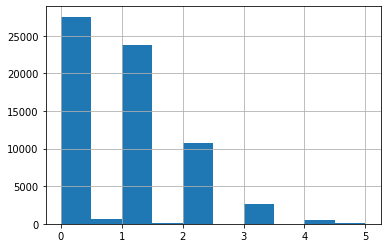

In [16]:
dental_numeric = pd.to_numeric(dental['DentalGrade'], errors="coerce")
print(f"Numeric entries = {dental_numeric.count()}")
print(f"Numeric entries <= 5 = {dental_numeric[dental_numeric <= 5].count()}")
print(dental_numeric.unique())

dental_numeric[dental_numeric <= 5].hist()
plt.show()

In above, `40.` is most likely `4`, `32` could be `3` or `2`, and `21` could be `2` or `1`. For `0.25`, `0.3`, `0.5`, `1.5`, `2.5` it's hard to tell.

### Baby teeth
Not much numerical information here, so can likely safely set these to 0, as kittens are unlikely to have any plaque or gingivitis.

In [17]:
dental_baby = dental.loc[dental["DentalGrade"].str.contains('dec|baby|teething|kitten|juv', na=False), "DentalGrade"]

print(dental_baby.count())
print(dental_baby.unique())

1212
['decid' 'deciduous' 'dec' 'retaiend deciduous canines' 'deciduous '
 'deciduous teeth ' 'deciduous/gingivitis' 'juvinile' 'decidious'
 'decisious' 'decusuous' 'teething' 'teething ' 'teething  still' 'baby'
 'kitten' 'baby teeth ' 'baby teeth' 'deciduous falling out'
 'deciduous dentition' '0 baby teeth' 'deciduous teeth' 'juv'
 'kitten gingivitis' '0/5 deciduous']


### Mentions of "gingi"
Reasonable amount of numeric data here, could keep most with the assumption that values are on the standard 0-4 scale.

In [18]:
dental_gingi = dental.loc[dental["DentalGrade"].str.contains('gingi', na=False), "DentalGrade"]

print(dental_gingi.count())
print(dental_gingi.unique())

115
['nasty gingivitis. grade 2 plaque' '2 + +++ gingivitis' 'gingivitis 4+'
 '2/4 calculus pms + gingivitis' 'deciduous/gingivitis'
 'lhs>rhs. gingivits.  grd 1 both sides' '0 but some gingivitis'
 '3-4 obvious gingival inflammation and plaque build up' '1 gingivitis'
 '2 gingivitis and tartar'
 '2/4 with gingivitis & some gum resorptin on both upper canines'
 'kitten gingivitis' '1/4 severe gingivitis ' '1-2 tartart no gingivitis'
 '2 gingivitis']


### Number of entries listed as "{}/4"

In [22]:
dental_outof4 = dental.loc[dental["DentalGrade"].str.contains('/4', na=False), "DentalGrade"]

print(dental_outof4.count())
print(dental_outof4.unique())

15173
['2/4' '3/4' '1/4' '0/4' '0.5/4' '2/4 calculus pms + gingivitis'
 '1/4 calculus pms' '0/4 ' '0/4 dental exam nad missing lower i3 rhs'
 '1/4 mild tartar carnassials'
 '1/4 mild calculus on upper pms otherwise teeth good'
 '1/4 mild plaque upper canines' '1-2/4' '3/4-5' '3.5/4' '0-1/4' '2-3/4'
 '4/4' '1/4 ' '2/4 ' '0.25/4 ' '1.5/4' '0.25/4' '2.5/4' '<1/4'
 '2/4 over molars' '3/4-few teeth remain' '2/4 molars mostly' ' 0/4'
 '2/4+ tooth root abcess' '1-4/4' '1/4 pm4s only ' '3-4/4'
 '2/4 with gingivitis & some gum resorptin on both upper canines' '1+/4'
 '1/4 severe gingivitis ' 'late 2/4' '0/4 - many teeth missing' '3/4 '
 '1/4 ump4s' '1-3/4' '2/4 - suspect neck lesion 409' '3/4 tartar' '>1/4']


### Number of entries listed as "{}/5"

In [24]:
dental_outof5 = dental.loc[dental["DentalGrade"].str.contains('/5', na=False), "DentalGrade"]

print(dental_outof5.count())
print(dental_outof5.unique())

2239
['1/5' '1/5 - needs dental scaling and polishing' '1.5/5' '0/5' '2/5'
 '3/5' '2-3/5' '1-2/5' '4/5' '5/5' '1+/5' '0-1/5' '3.5/5' '2.5/5'
 '1/5 with carrie' '2/5 pm4 ' '0/5 deciduous' '0.5/5']


### Contains a "/"

In [62]:
dental_outof = pd.DataFrame(dental.loc[dental["DentalGrade"].str.contains('/', na=False), "DentalGrade"], columns=['DentalGrade'])

print(dental_outof["DentalGrade"].count())
print(dental_outof["DentalGrade"].unique())

18915
['2/2' '2/4' '3/4' '1/4' '0/4' '0.5/4' '0/1'
 '2/4 calculus pms + gingivitis' '1/5'
 '1/5 - needs dental scaling and polishing' '1/4 calculus pms' '0/4 '
 '0/4 dental exam nad missing lower i3 rhs' '1/4 mild tartar carnassials'
 '1/6' '1.5/5' '2/6' '3/6'
 '1/4 mild calculus on upper pms otherwise teeth good'
 '1/4 mild plaque upper canines' '4/6' '0/5' '2/5' '3/5' '6/6' '1-2/4'
 '3/4-5' '2-3/5' '1-2/5' '1/1' '0/0' '1/2' '3.5/4' '1/3' '0.5/3' '4/5'
 '5/9' '0-1/4' '2-3/4' '5/5' '2/3' '4/4' '1/4 ' '3/3' '2/4 '
 'deciduous/gingivitis' '0.25/4 ' '1.5/4' '0.25/4' '2.5/4' '1/trace'
 '0-1/9' '<1/4' '1/0' 'g0/c1' 'g1/c0' 'c2/g1' 'c0/g0' 'c1/g1' 'c1/g2'
 'c0/g1' '2/4 over molars' '3/4-few teeth remain' '2/4 molars mostly'
 '1+/5' '6/9' '2/1' 'c2/g2' 'c1/g3' '0-1/5' '0-i/iv' '0/iv' 'i-ii/iv'
 '0/3' '-12/3' '<1/3' '2-3/3' '2/2 ' '1/36' ' 0/4'
 '2/4+ tooth root abcess' '1-4/4' '1/4 pm4s only ' '2/9' '3-4/4'
 '2/4 with gingivitis & some gum resorptin on both upper canines' '1/9'
 '3.5/5' '2.5/

In [66]:
dental_outof_split = dental_outof["DentalGrade"].str.split(pat = "/", expand=True)

dental_outof_split.rename(columns={0: 'left', 1: 'right', 2: 'end'}, inplace=True)

# print(dental_outof_split["left"].unique())
# print(dental_outof_split["right"].unique())
# print(dental_outof_split["end"].unique())

In [69]:
dental_split = pd.concat([dental_outof, dental_outof_split], axis=1)
dental_split.head()

,DentalGrade,left,right,end
10693,2/2,2,2,None
10694,2/2,2,2,None
10695,2/2,2,2,None
10696,2/2,2,2,None
10877,2/4,2,4,None


In [70]:
dental_split[dental_split['end'] == '3']

,DentalGrade,left,right,end
577300,1/3 0/3,1,3 0,3
577301,1/3 0/3,1,3 0,3
577302,1/3 0/3,1,3 0,3
577303,1/3 0/3,1,3 0,3
577304,1/3 0/3,1,3 0,3
577305,1/3 0/3,1,3 0,3
577306,1/3 0/3,1,3 0,3


### There's a dog in here!

In [19]:
dental[dental["DentalGrade"].str.contains('puppy', na=False)]

,Patient Number,DentalGrade
377637,8360360,puppy
377638,8360360,puppy
377639,8360360,puppy
377640,8360360,puppy
377641,8360360,puppy
377642,8360360,puppy
377643,8360360,puppy
377644,8360360,puppy
377645,8360360,puppy
377646,8360360,puppy


In [20]:
dental[dental["DentalGrade"] == '5/9']

,Patient Number,DentalGrade
100836,7416676,5/9
100837,7416676,5/9
100838,7416676,5/9
511741,7744321,5/9
511742,7744321,5/9
511743,7744321,5/9
